Kindly upvote if you like this notebook,<br>
Any suggestions and feedback are most welcome

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install altair

In [ ]:
import altair as alt

In [ ]:
pd.options.display.max_rows = 5000

In [ ]:
Space_Corrected_df=pd.read_csv('/kaggle/input/all-space-missions-from-1957/Space_Corrected.csv')

In [ ]:
Space_Corrected_df.columns

Lets do some preprocessing

In [ ]:
Space_Corrected_df.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1,inplace=True)

In [ ]:
location_df = Space_Corrected_df['Location'].str.split(',',expand=True)[[1,2,3]]
location_df[3].fillna(' ',inplace=True)
location_df['Country']=location_df[2]+', '+location_df[3]
Space_Corrected_df['Area']=location_df[1]
Space_Corrected_df['Country']=location_df['Country']

In [ ]:
Space_Corrected_df.rename(columns={' Rocket':'Cost(Millions USD)','Country':'City_Country'},inplace=True)
Space_Corrected_df['Cost(Millions USD)'].fillna(0,inplace=True)

Fixing few values in Area and country column, Kindly bear with me

In [ ]:
Space_Corrected_df['City_Country'].fillna(0,inplace=True)
for index in list(Space_Corrected_df[Space_Corrected_df['City_Country']==0].index):
    if Space_Corrected_df['Area'].iloc[index] not in [' Shahrud Missile Test Site',' Yellow Sea']:
        Space_Corrected_df['City_Country'].iloc[index] = Space_Corrected_df['Area'].iloc[index]
    else:
        Space_Corrected_df['Area'].iloc[index] = Space_Corrected_df['Location'].str.split(',',expand=True)[1].iloc[index]
Space_Corrected_df['City_Country'].replace(0,np.nan,inplace=True)

In [ ]:
Space_Corrected_df['Cost(Millions USD)']= Space_Corrected_df['Cost(Millions USD)'].str.replace(',', '')
Space_Corrected_df['Cost(Millions USD)']=Space_Corrected_df['Cost(Millions USD)'].astype(float)
Space_Corrected_df['Date']=pd.to_datetime(Space_Corrected_df.Datum,dayfirst=True)
Space_Corrected_df['Date']=Space_Corrected_df['Date'].astype(str).str.split(' ',expand=True)
Space_Corrected_df['Year']=Space_Corrected_df['Date'].str[:4]
Space_Corrected_df['Month']=Space_Corrected_df['Date'].str[5:7]

In [ ]:
Space_Corrected_df['Country']=Space_Corrected_df['City_Country']

In [ ]:
Space_Corrected_df['Country'].replace([' Alaska,  USA',' Florida,  USA',' Marshall Islands,  USA',' Texas,  USA',' Virginia,  USA',' California,  USA',' Florida,  USA'],'USA',inplace=True)
Space_Corrected_df['Country'].replace([' China,  ',' China'],'China',inplace=True)
Space_Corrected_df['Country'].replace([' French Guiana,  France',' Algeria,  France'],'France',inplace=True)
Space_Corrected_df['Country'].replace([' Russia',' Russia,  '],'Russia',inplace=True)
Space_Corrected_df['Country'].replace([' India,  ',' India,  '],'India',inplace=True)
Space_Corrected_df['Country'].replace([' Japan ',' Japan,  ',' Japan'],'Japan',inplace=True)

Looks like everything is fixed, lets start the EDA

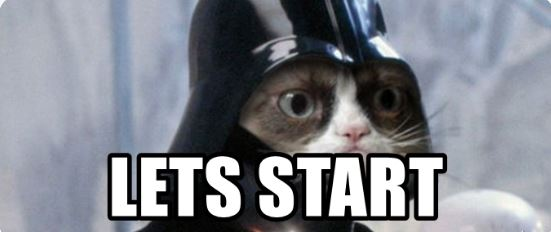

In [ ]:
country_company=Space_Corrected_df.groupby(['Country']).size().reset_index().rename(columns={0:'count'})

These are the countries with highest number of launches

In [ ]:
alt.Chart(country_company).mark_bar().encode(
    y='count:Q',
    x=alt.X('Country:N', sort='x')
).properties(width=1000)

Russia and USA has close competition for launching vehicle in space. I think kazakhstan (former USSR) can also be counted in Russia

In [ ]:
company_count=Space_Corrected_df.groupby(['Company Name','Status Mission']).size().reset_index().rename(columns={0:'count'})
alt.Chart(company_count).mark_bar().encode(
    y='count:Q',
    x=alt.X('Company Name:N'),
    color='Status Mission'
).properties(width=1000)

Difficult to analyze as RVSN USSR has highest number of launches. Lets remove it and check

In [ ]:
alt.Chart(company_count[company_count['Company Name']!='RVSN USSR']).mark_bar().encode(
    y=alt.X('count:Q', stack="normalize"),
    x=alt.X('Company Name:N'),
    color='Status Mission'
).properties(width=1000)

If we look from percentage point of view, few company like Sanda, VKS RF etc has huge number of failures(Includes Partial and prelaunch failure).

In [ ]:
Space_Corrected_df['Cost(Millions USD)'].fillna(0,inplace=True)

In [ ]:
space_launch_cost=Space_Corrected_df.groupby(['Country','Year']).agg({'Cost(Millions USD)':'sum'}).reset_index()

In [ ]:
alt.Chart(space_launch_cost).mark_line().encode(
    x='Year',
    y='Cost(Millions USD)',
    color='Country'
).properties(width=1000)

In [ ]:
launch_year=Space_Corrected_df['Year'].value_counts().rename_axis('Year').reset_index(name='counts')
alt.Chart(launch_year).mark_bar().encode(
    y='counts',
    x=alt.X('Year')
).properties(width=1000)

* There's no cost in many years, so graph shows 0
* USA is the most payout country in the world
* There is huge spike around mid 1960's to mid 1970's, may be due to Apollo moon mission. 
* Key the race to space has started in 21st century. After USA, France spends most in space missions
* If we look closely we see that over the years number of launches have increased but cost of launch has decreased, I think it is safe to say that in near future space travel might be cheap than today 

In [ ]:
launch_month=Space_Corrected_df['Month'].value_counts().rename_axis('Month').reset_index(name='counts')
alt.Chart(launch_month).mark_line(point=True).encode(
    x='Month',
    y='counts'
).properties(width=1000)

I don't see much influence of month

In [ ]:
country_rocketstatus=Space_Corrected_df.groupby(['Country','Status Rocket']).size().reset_index().rename(columns={0:'count'})
alt.Chart(country_rocketstatus).mark_line(point=True).encode(
    x='Country',
    y='count',
    color='Status Rocket'
).properties(width=1000)

* China has most number of active rocket, even more than USA
* Russia and USA has most retired rocket.
* Counties like India, Iran, New Zealand and few other countries had more number of active rockets compared to retired.
* As Russia and USA started have there space missions, early I think that's they have more number of retired rockets. I think it is also save to conclude that over the time space debris might increase due to retirement of rockets in space.